<!-- DON'T EDIT THIS CELL! -->
<!-- TYPE SHIFT+ENTER AND GO TO THE NEXT CELL -->

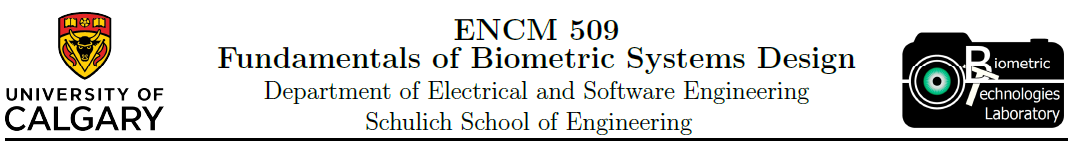

# ENCM 509 - Lab 2 Report

**Student Names**


**Mushtaba Al Yasseen (30094000)**
\
**Usman Khan (30092202)**

Importing all necessary libraries

In [11]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.patches import Rectangle
import matplotlib as mpl

from scipy import ndimage as ndi

from sklearn.feature_extraction.image import extract_patches_2d

from skimage.io import imread, imsave
from skimage.util import img_as_ubyte, invert
from skimage.exposure import equalize_hist, equalize_adapthist
from skimage.filters import median, gaussian
from skimage.filters import gabor_kernel
from skimage.util import invert
from skimage.exposure import equalize_adapthist

# custom functions
from utils_encm.blockproc import blockproc
from utils_encm.poincare import calculate_singularities
from utils_encm.segmentation import segmentation
from utils_encm.normalization import normalize
from utils_encm.gabor_filter import gabor_filter
from utils_encm.frequency import ridge_freq
from utils_encm.orientation import calculate_angles, visualize_angles
from utils_encm.crossing_number import calculate_minutiae
from utils_encm.skeletonize import skeletonize
from utils_encm.align2 import align2
from utils_encm.MatchGaborFeat import MatchGaborFeat
from utils_encm.align2 import align2
from utils_encm.match import match

# setting the default colormap for images only
mpl.rc('image', cmap='gray')

# **Introduction:**
In this lab we will be focusing on image processing and fingerprint matching. We will be using fingerprints collected by using the _Digital Persona UareU 4500_. We will be focusing on two main matching algorithms, matching based on Minutiae count (ridge ending and bifurcation), and matching based on scores obtained by Gabor filtering. In addition, we will also change the parameters of Gabor filtering such as the angle and frequency in order to see if it has a visual impact on the processed fingerprint image. Lastly, after running both types of matching algorithms, we will also select thresholds in order to see their impact on the number of true positive matches and false negative matches.

## **Exercise 1:**

Loading the fingerprint image

In [12]:
left_thumb1_good = img_as_ubyte(imread('./fingerPrints/MushtabaLeft/5.bmp', as_gray=True))

Auxiliary methods

In [13]:
def plot_gabor_filter(img, angle, freq):
    r, c = img.shape
    ysize = int(np.floor(r/10))

    t = int(np.floor(ysize/8))
    fi = np.real(gabor_kernel(freq, theta=angle, n_stds=t))

    # 'mode' specifies how the convolution algorithm will deal with the borders
    If1 = equalize_adapthist(ndi.convolve(img, fi, mode='wrap'))
    # normalize
    If1 = ((If1 - np.min(If1)) / (np.max(If1) - np.min(If1))) * 255
    #print(np.min(If1), np.max(If1))

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(img, cmap='gray'); plt.title('Original image')
    plt.subplot(1,3,2)
    plt.imshow(fi, cmap='gray'); plt.title('Filter used')
    plt.subplot(1,3,3)
    plt.imshow(If1, cmap='gray'); plt.title('Image processed');

In [14]:
def fingerprint_processing(img, block_size=16, threshold=0.4):
    output = {}
    
    # normalization - removes the effects of sensor noise and finger pressure differences.
    normalized_img = normalize(img.copy(), float(100), float(100))
    output['normalized_img'] = normalized_img
    
    # segmentation
    (segmented_img, normim, mask) = segmentation(normalized_img, 
                                                 block_size, 
                                                 threshold)
    output['segmented_img'] = segmented_img
    output['normim'] = normim
    output['mask'] = mask
    
    # orientation estimation
    angles = calculate_angles(normalized_img, 
                              W=block_size, smooth=True)
    output['angles'] = angles
    
    # find the overall frequency of ridges
    freq = ridge_freq(normim, mask, angles, 
                      block_size, kernel_size=5, 
                      minWaveLength=5, maxWaveLength=15)
    output['freq'] = freq
    
    # create gabor filter and do the actual filtering
    gabor_img = gabor_filter(normim, angles, freq, block_size)
    output['gabor_img'] = gabor_img
    
    # create the skeleton
    thin_image = skeletonize(gabor_img)
    output['thin_image'] = thin_image
    
    # find the minutiae
    minutiae_lst, minutiae_img, minutiae_arr = calculate_minutiae(thin_image, mask)
    output['minutiae_lst'] = minutiae_lst
    output['minutiae_img'] = minutiae_img
    output['minutiae_array'] = minutiae_arr
    
    # singularities
    singularities_lst, singularities_img = calculate_singularities(thin_image, 
                                                                   angles, block_size, 
                                                                   mask)
    output['singularities_lst'] = singularities_lst
    output['singularities_img'] = singularities_img
    
    return output

Below we will perform Gabor filtering on our fingerprint image while adjusting the _frequency_ and _angle_ parameters to see how it affects the fingerprint image.

#### Set #1 Baseline - Frequency (0.11), Angle ($\pi/4, 45^{\circ }$)

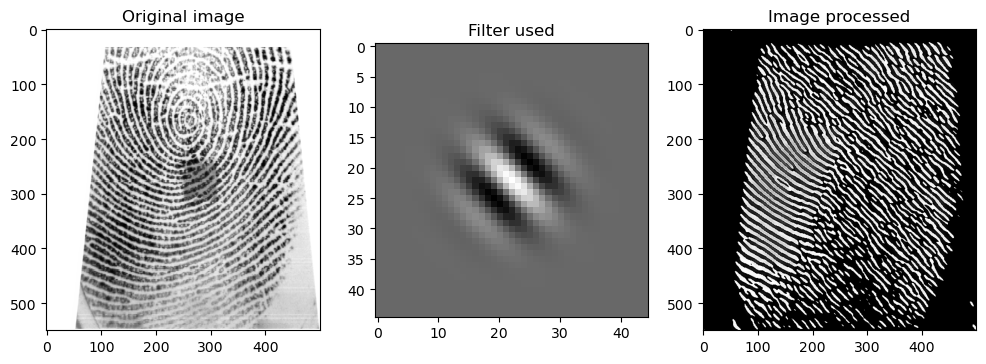

In [15]:
plot_gabor_filter(left_thumb1_good, angle=-np.pi/4, freq=0.11)

#### Set #2 - Frequency (0.11), Angle ($\pi/2, 90^{\circ }$)

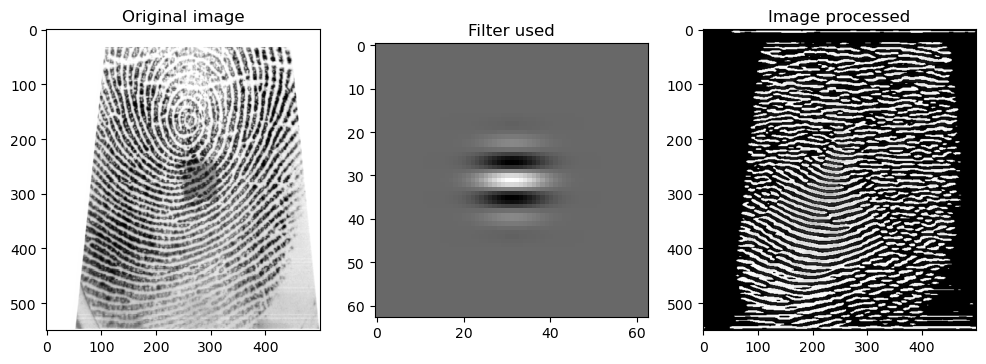

In [16]:
plot_gabor_filter(left_thumb1_good, angle=-np.pi/2, freq=0.11)

#### Set #3 - Frequency (0.80), Angle ($\pi/4, 45^{\circ }$)

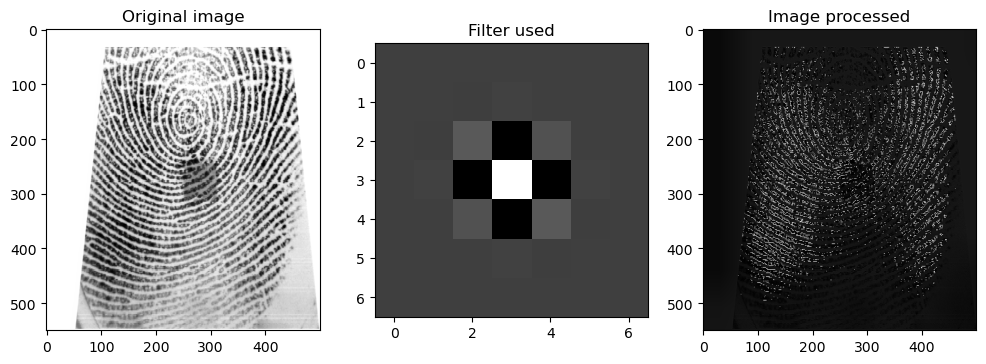

In [17]:
plot_gabor_filter(left_thumb1_good, angle=-np.pi/4, freq=0.80)

#### Set #4 - Frequency (0.80), Angle ($\pi/2, 90^{\circ }$)

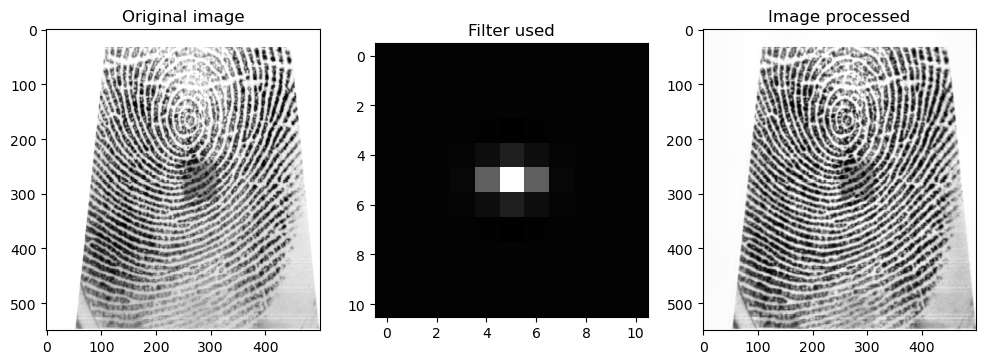

In [18]:
plot_gabor_filter(left_thumb1_good, angle=-np.pi/2, freq=0.80)

#### Analysis Of Data:

Gabor filtering is used enhance the ridges using directional filters. For the first set of parameters (baseline), we set the angle to 45 degrees, with a frequency of 0.11. At first glance, looking at the baseline set, we can see that the filter used is angled at a 45 degree angle which makes sense since this is what we had set it at. Moreover, the processed image is where we are able to see the effects of the angle parameter more clearly, as the filtering pattern is also angled at a 45 degree angle, enhancing part of the ridges as well. Set #2 is very similar to the first set, however, we instead changed the angle to 90 degrees. Evidently, this changed the filter used to be angled at 90 degrees, while also setting the filter pattern of the processed image at 90 degrees as well. Interestingly enough, by changing the angle, we also changed the area of the fingerprint that was enhanced. At 90 degrees, more of the bottom of the print was now enhanced instead of the top-left being enhanced at 45 degrees, which makes sense since we set the angle to $\pi / 2$. Now, for set #3, we increased the frequency to 0.80 at an angle of 45 degrees. Although more ridges were now "enhanced" compared to set #1 and #2, the processed image was now more noisy, and we noticed that at this angle, the noisiness of the processed image starts to decline as you start to increase the frequency past 0.80. Now, interestingly enough, if we keep the same frequency of 0.80, but change the angle to 90 degrees, the ridges of the processed image are enhanced, and the image is much more clear. This makes sense, as at a larger angle, the gabor filter can enhance a larger area of the fingerprint compared to being limited at 45 degrees.

## **Exercise 2:**

Now we will develop a simple identification procedure to match one probed fingerprint to 9 different impressions, recording the scores for minutiae based matching.

In [19]:
probed_fingerprint = img_as_ubyte(imread('./fingerPrints/MushtabaLeft/5.bmp', as_gray=True))
probed_FP = fingerprint_processing(probed_fingerprint, block_size=12, threshold=0.1)

In [20]:
# Minutiae matching
# NOTE: this processing will take some time (about 20min). Go to get some coffee/tea :)

for i in range(1, 5):
    # Align the two fingerprints for better matching
    fingerprint_impression = img_as_ubyte(imread(f'./fingerPrints/MushtabaLeft/{i}.bmp', as_gray=True))
    impression_FP = fingerprint_processing(fingerprint_impression, block_size=12, threshold=0.1)
    imSkeletonAlign, minutiaArrayAlign = align2(probed_FP, impression_FP)
    impression_FP['imSkeletonAlign'] = imSkeletonAlign
    impression_FP['minutiaArrayAlign'] = minutiaArrayAlign

    match_threshold = 6
    score = match(probed_FP, impression_FP, threshold2=match_threshold)
    print(f'score for MushtabaLeft/{i}.bmp minutiae: {score:.4f}\n')

number of matched minutiae: 91
distance total computed : 384
number of minutiae in input image: 2251
number of minutiae in database image: 443
score for MushtabaLeft/1.bmp minutiae: 0.0676

number of matched minutiae: 173
distance total computed : 746
number of minutiae in input image: 4858
number of minutiae in database image: 443
score for MushtabaLeft/2.bmp minutiae: 0.0653

number of matched minutiae: 133
distance total computed : 577
number of minutiae in input image: 3509
number of minutiae in database image: 443
score for MushtabaLeft/3.bmp minutiae: 0.0673

number of matched minutiae: 99
distance total computed : 421
number of minutiae in input image: 3188
number of minutiae in database image: 443
score for MushtabaLeft/4.bmp minutiae: 0.0545



In [21]:
# Minutiae matching
# NOTE: this processing will take some time (about 20min). Go to get some coffee/tea :)

for i in range(6, 11):
    # Align the two fingerprints for better matching
    fingerprint_impression = img_as_ubyte(imread(f'./fingerPrints/MushtabaLeft/{i}.bmp', as_gray=True))
    impression_FP = fingerprint_processing(fingerprint_impression, block_size=12, threshold=0.1)
    imSkeletonAlign, minutiaArrayAlign = align2(probed_FP, impression_FP)
    impression_FP['imSkeletonAlign'] = imSkeletonAlign
    impression_FP['minutiaArrayAlign'] = minutiaArrayAlign

    match_threshold = 6
    score = match(probed_FP, impression_FP, threshold2=match_threshold)
    print(f'score for MushtabaLeft/{i}.bmp minutiae: {score:.4f}\n')

number of matched minutiae: 79
distance total computed : 334
number of minutiae in input image: 3405
number of minutiae in database image: 443
score for MushtabaLeft/6.bmp minutiae: 0.0411

number of matched minutiae: 207
distance total computed : 914
number of minutiae in input image: 3894
number of minutiae in database image: 443
score for MushtabaLeft/7.bmp minutiae: 0.0955

number of matched minutiae: 54
distance total computed : 217
number of minutiae in input image: 3538
number of minutiae in database image: 443
score for MushtabaLeft/8.bmp minutiae: 0.0271

number of matched minutiae: 144
distance total computed : 623
number of minutiae in input image: 3519
number of minutiae in database image: 443
score for MushtabaLeft/9.bmp minutiae: 0.0727

number of matched minutiae: 130
distance total computed : 586
number of minutiae in input image: 4003
number of minutiae in database image: 443
score for MushtabaLeft/10.bmp minutiae: 0.0585



#### Analysis Of Data:

ingerprint #5 was used as the "probed fingerprint"

| Fingerprint # | Minutiae Score |
|-----------------|-----------------|
| 1 | 0.0676 |
| 2 | 0.0653 |
| 3 | 0.0673 |
| 4 | 0.0545 |
| 6 | 0.0411 |
| 7 | 0.0955 |
| 8 | 0.0271 |
| 9 | 0.0727 |
| 10 | 0.0585 |

Now that we have the minutiae score for each of the fingerprints, we will choose a threshold in order to record the number of matches. As an example, we will choose three different thresholds. First we will choose a threshold that falls relatively in the middle of all the minutiae scores. We will accept any scores above the threshold, and wee will also reject any scores below the threshold.

Threshold #1 - 0.0585 (Middle)

True Positives - TP: 5/9 = 0.5555 (55.55%)
\
False Negatives - FN: 3/9 = 0.3333 (33.33%)

Threshold #2 - 0.0727 (Higher-range)

True Positives - TP: 1/9 = 0.1111 (11.11%)
\
False Negatives - FN: 7/9 = 0.7777 (77.77%)

Threshold #3 - 0.0411 (Lower-end)

True Positives - TP: 7/9 = 0.7777 (77.77%)
\
False Negatives - FN: 1/9 = 0.1111 (11.11%)

As shown above, for the first threshold in the mid-range, about half of the fingerprints matched as true positives, while only a third were matched as false negatives. The threshold chosen is also very crucial, as it impacts the matching score. For instance, for the second threshold, we chose a threshold on the higher-end of the minutiae scores. As a result, we actually ended up with a significant amount of false negatives (77%), as we essentially rejected anything below below the threshold. On the other hand, when we chose a threshold on the lower-end, we ended up with a significant amount of true positives (77%), as now we are accepting anything above the threshold, which also significantly reduced our false negatives score (11%).

## **Exercise 3:**

In [ ]:
probed_fingerprint = img_as_ubyte(imread('./fingerPrints/MushtabaLeft/5.bmp', as_gray=True))
probed_FP = fingerprint_processing(probed_fingerprint, block_size=12, threshold=0.1)


score for MushtabaLeft/1.bmp gabor: 12.6499

score for MushtabaLeft/2.bmp gabor: 12.3960

score for MushtabaLeft/3.bmp gabor: 12.3334

score for MushtabaLeft/4.bmp gabor: 13.4593



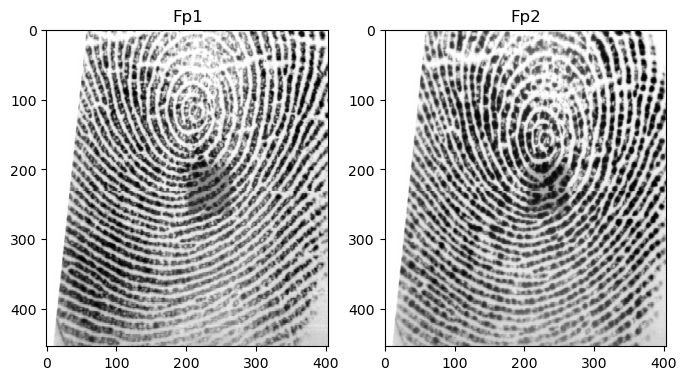

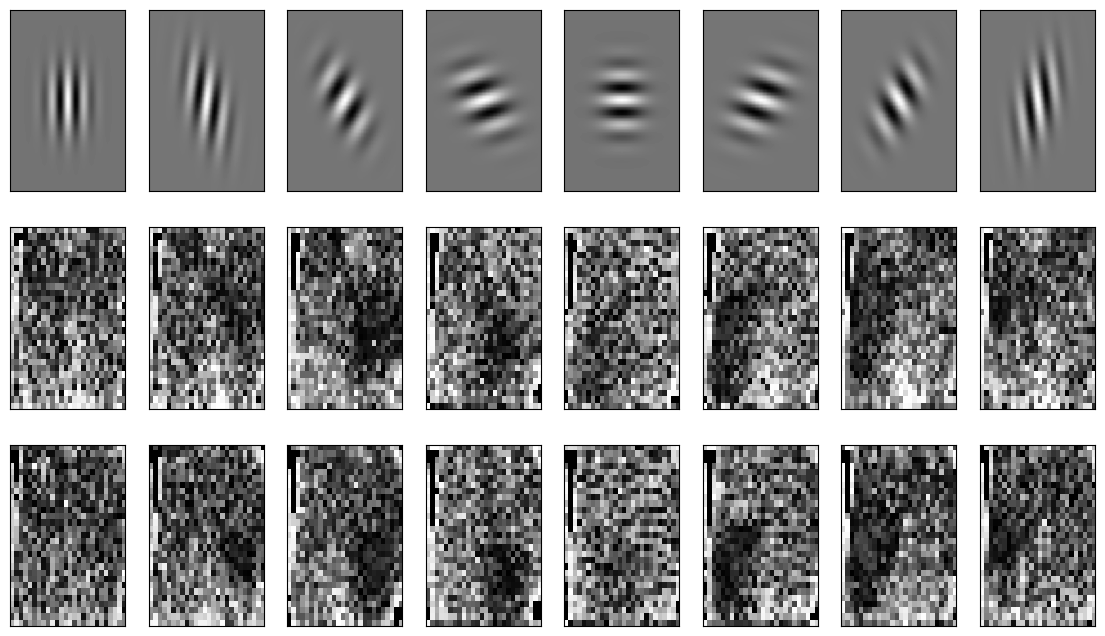

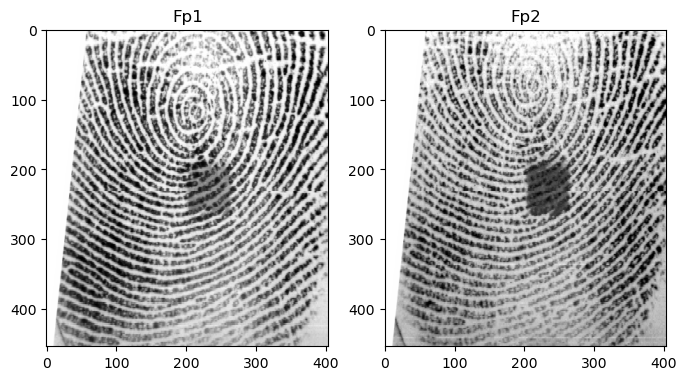

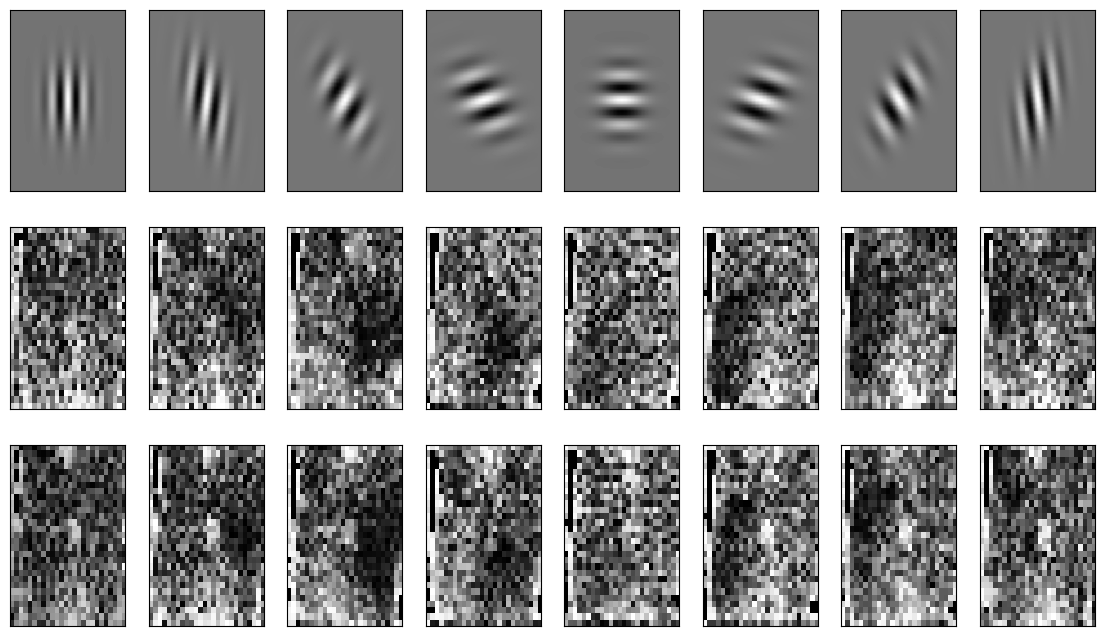

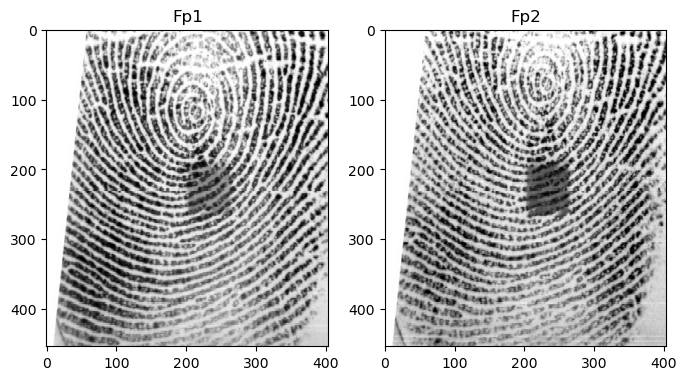

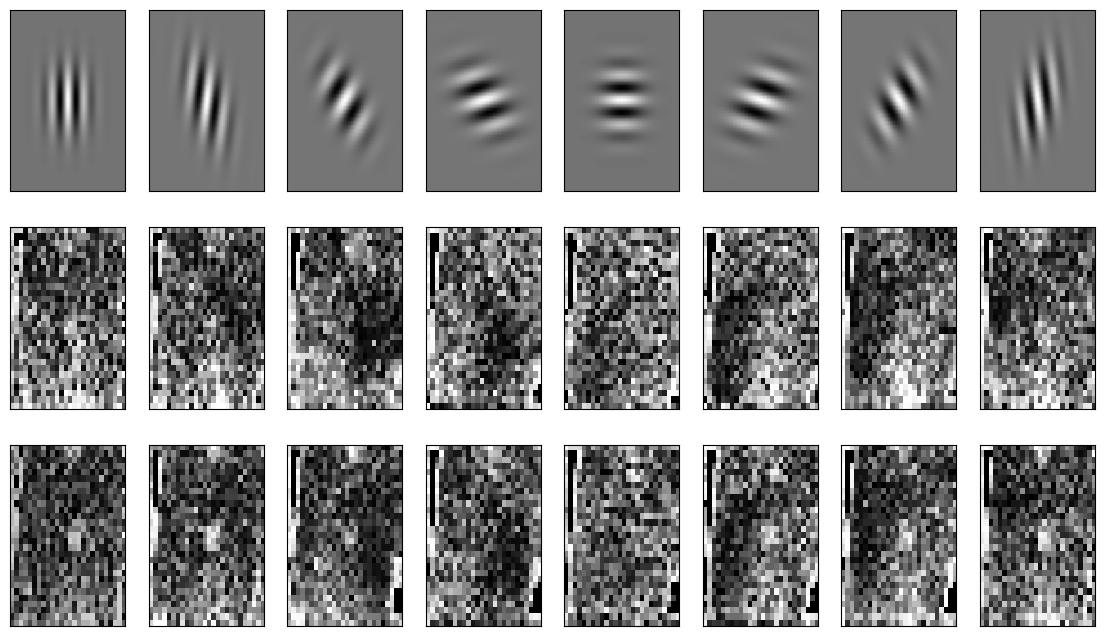

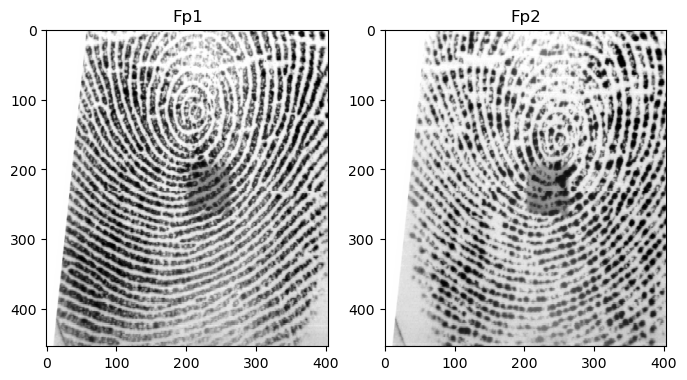

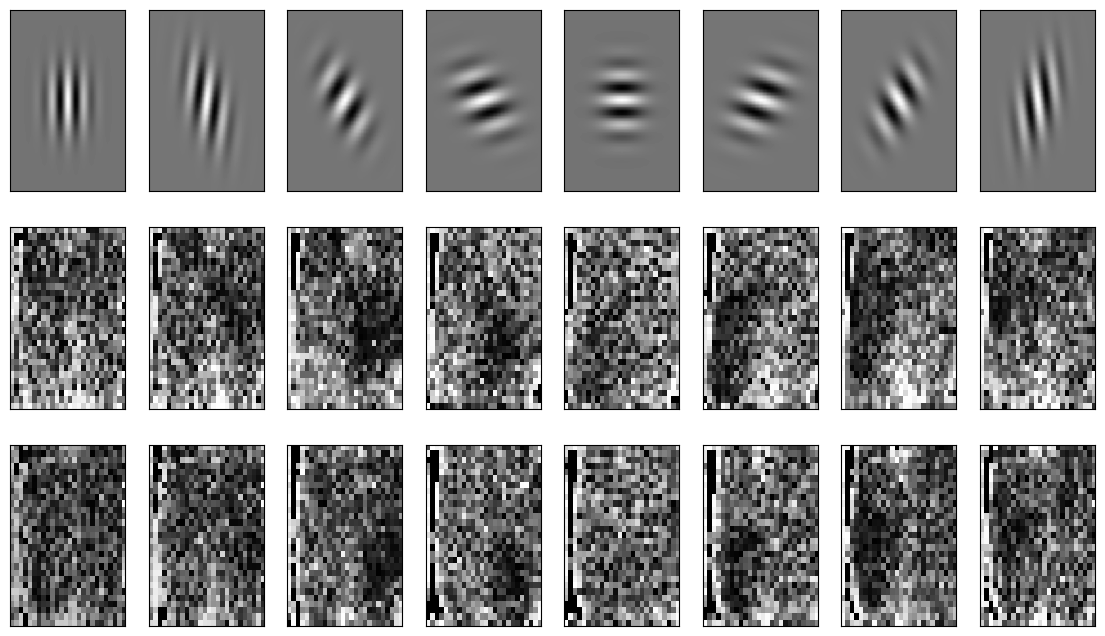

In [ ]:
# Minutiae matching
# NOTE: this processing will take some time (about 20min). Go to get some coffee/tea :)

for i in range(1, 5):
    # Align the two fingerprints for better matching
    fingerprint_impression = img_as_ubyte(imread(f'./fingerPrints/MushtabaLeft/{i}.bmp', as_gray=True))

    score = MatchGaborFeat(probed_fingerprint, fingerprint_impression, plot_res=True)
    print(f'score for MushtabaLeft/{i}.bmp gabor: {score:.4f}\n')

score for MushtabaLeft/6.bmp gabor: 11.9513

score for MushtabaLeft/7.bmp gabor: 12.7456

score for MushtabaLeft/8.bmp gabor: 11.8561

score for MushtabaLeft/9.bmp gabor: 11.9791

score for MushtabaLeft/10.bmp gabor: 12.9908



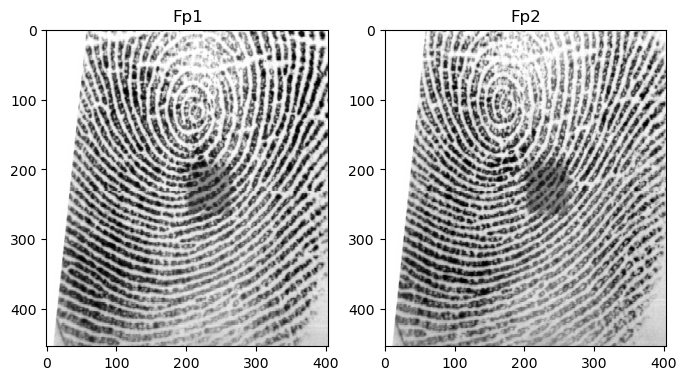

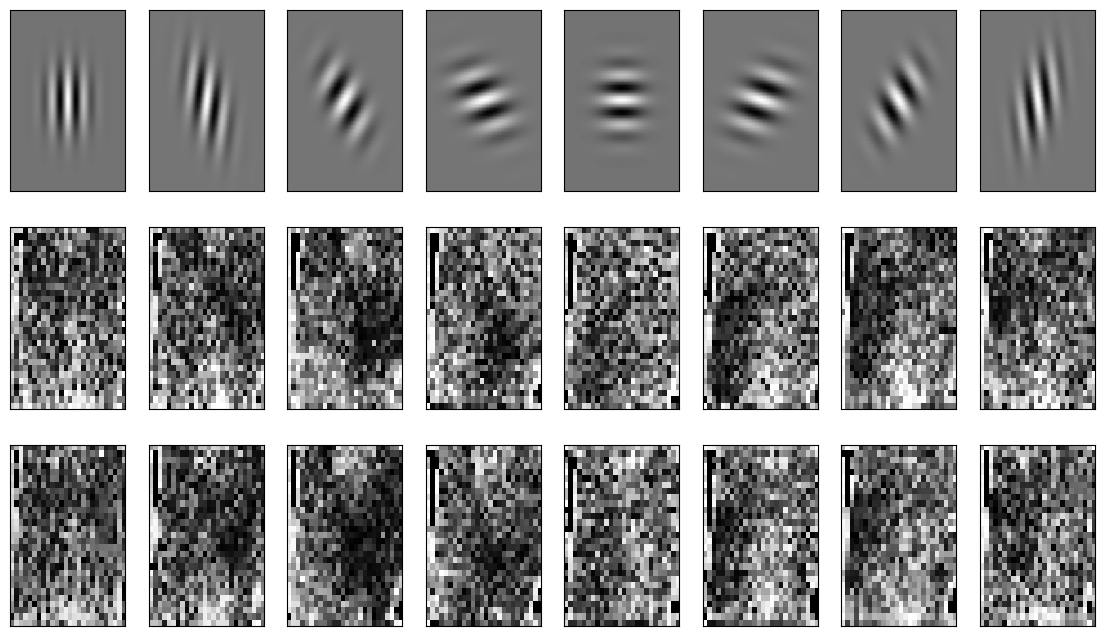

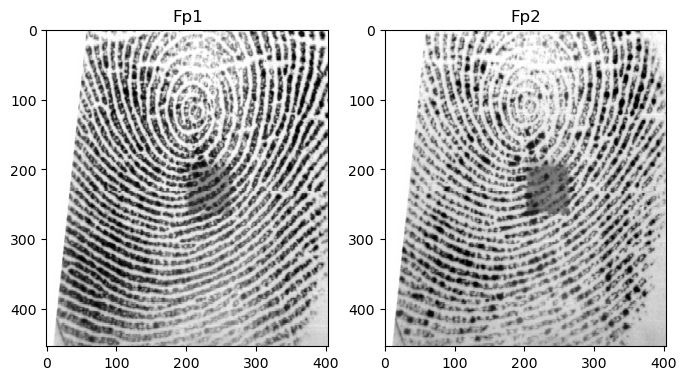

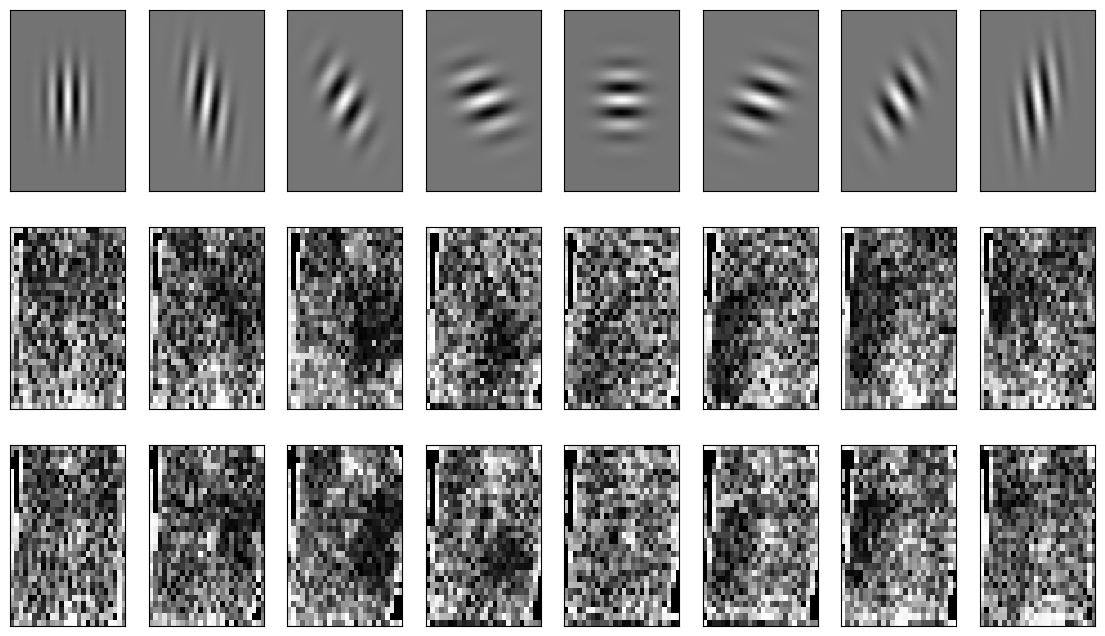

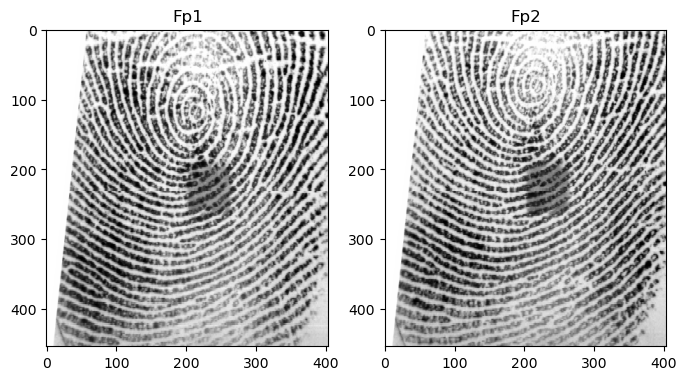

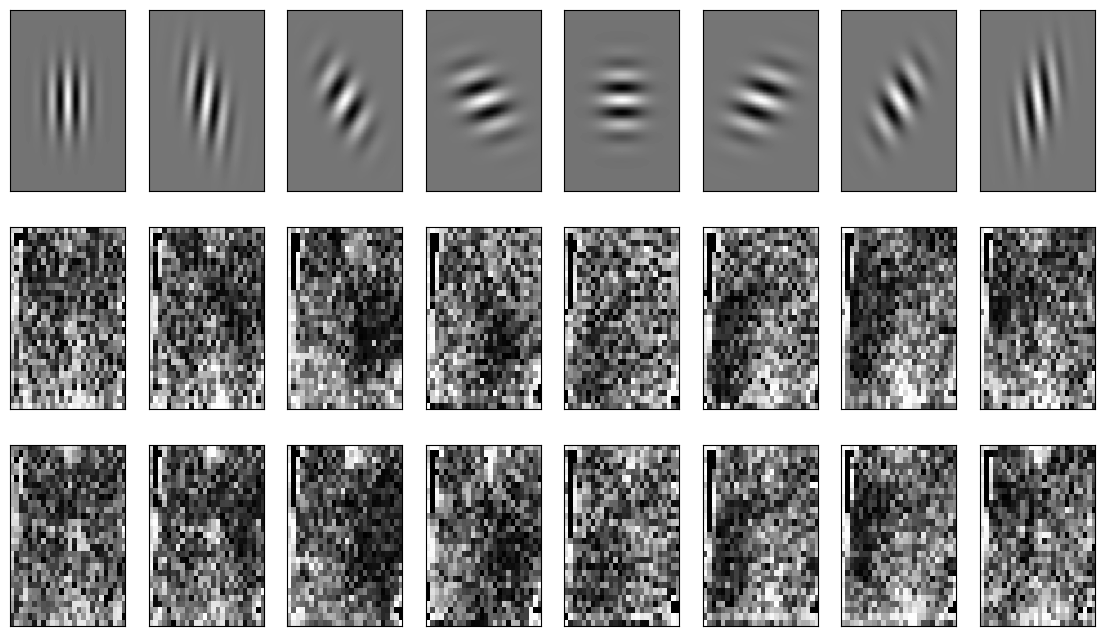

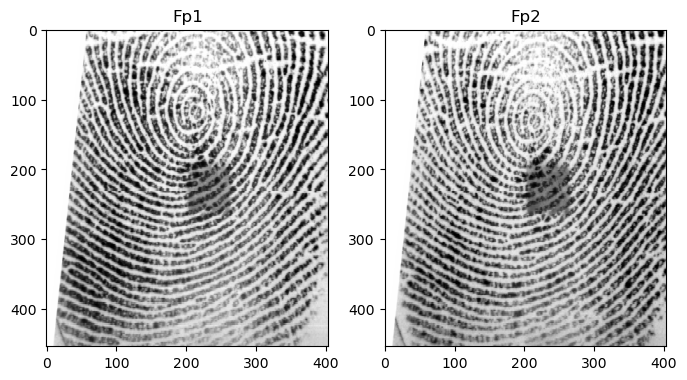

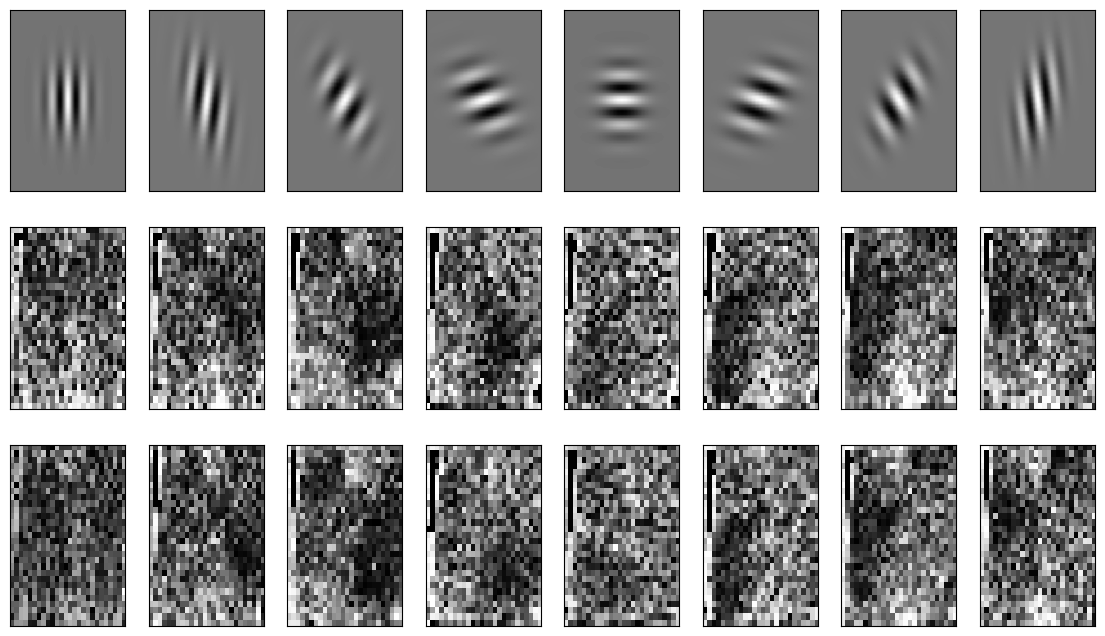

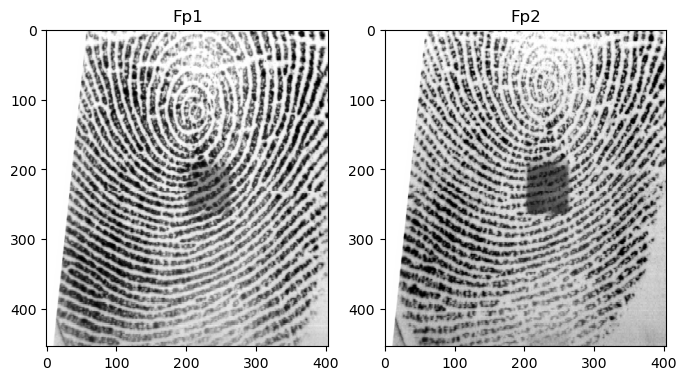

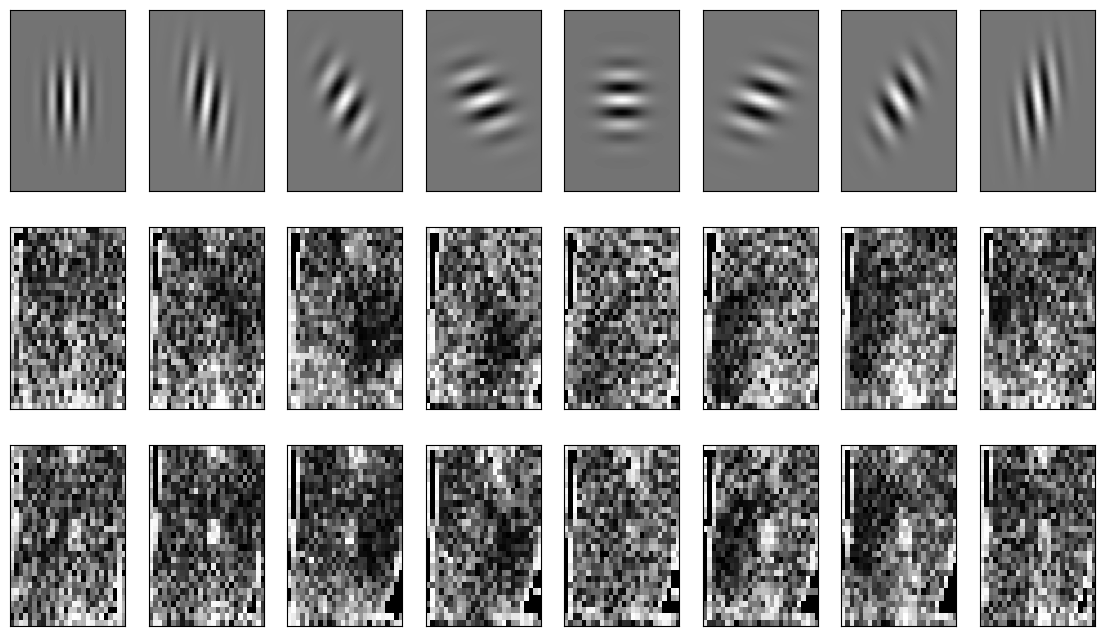

In [ ]:
for i in range(6, 11):
    # Align the two fingerprints for better matching
    fingerprint_impression = img_as_ubyte(imread(f'./fingerPrints/MushtabaLeft/{i}.bmp', as_gray=True))

    score = MatchGaborFeat(probed_fingerprint, fingerprint_impression, plot_res=True)
    print(f'score for MushtabaLeft/{i}.bmp gabor: {score:.4f}\n')

#### Analysis Of Data:

ingerprint #5 was used as the "probed fingerprint"

| Fingerprint # | Gabor Score |
|-----------------|-----------------|
| 1 | 12.6499 |
| 2 | 12.3960 |
| 3 | 12.3334 |
| 4 | 13.4593 |
| 6 | 11.9513 |
| 7 | 11.8561 |
| 8 | 11.9791 |
| 9 | 12.9908 |

Now that we have the gabor score for each of the fingerprints, we will choose a threshold in order to record the number of matches. As an example, we will choose three different thresholds. First we will choose a threshold that falls relatively in the middle of all the gabor scores. We will reject any scores above the threshold, and we will also accpet any scores below the threshold. This is because the better gabor score is the lower score

Threshold #1 - 12.3960 (Middle)

True Positives - TP: 4/9 = 0.444 (44.44%)
\
False Negatives - FN: 4/9 = 0.444 (44.44%)

Threshold #2 - 12.6499 (Higher-range)

True Positives - TP:  7/9 = 0.7777 (77.77%)
\
False Negatives - FN: 1/9 = 0.1111 (11.11%) 

Threshold #3 - 11.8561 (Lower-end)

True Positives - TP: 1/9 = 0.1111 (11.11%)
\
False Negatives - FN: 7/9 = 0.7777 (77.77%) 

As shown above, for the first threshold in the mid-range, about half of the fingerprints matched as true positives and about half were also matched as false negatives.The threshold chosen is also very crucial, as it impacts the matching score. For instance, for the second threshold, we chose a threshold on the higher-end of the gabor scores. As a result, we actually ended up with a significant amount of True Postitives (77%), as we essentially rejected anything above the threshold. On the other hand, when we chose a threshold on the lower-end, we ended up with a significant amount of false negatives (77%), as now we are accpeting anything below the threshold, which also significantly reduced our true postive score (11%).

## **Exercise 4:**

In [ ]:
# Minutiae matching
# NOTE: this processing will take some time (about 20min). Go to get some coffee/tea :)

for i in range(1, 6):
    # Align the two fingerprints for better matching
    fingerprint_impression = img_as_ubyte(imread(f'./fingerPrints/UsmanLeft/{i}.bmp', as_gray=True))
    impression_FP = fingerprint_processing(fingerprint_impression, block_size=12, threshold=0.1)
    imSkeletonAlign, minutiaArrayAlign = align2(probed_FP, impression_FP)
    impression_FP['imSkeletonAlign'] = imSkeletonAlign
    impression_FP['minutiaArrayAlign'] = minutiaArrayAlign

    match_threshold = 6
    score = match(probed_FP, impression_FP, threshold2=match_threshold)
    print(f'score for MushtabaLeft/{i}.bmp minutiae: {score:.4f}\n')

number of matched minutiae: 198
distance total computed : 935
number of minutiae in input image: 6002
number of minutiae in database image: 443
score for MushtabaLeft/1.bmp minutiae: 0.0614

number of matched minutiae: 88
distance total computed : 409
number of minutiae in input image: 4046
number of minutiae in database image: 443
score for MushtabaLeft/2.bmp minutiae: 0.0392

number of matched minutiae: 0
distance total computed : 0
number of minutiae in input image: 0
number of minutiae in database image: 443
score for MushtabaLeft/3.bmp minutiae: 0.0000

number of matched minutiae: 187
distance total computed : 860
number of minutiae in input image: 7217
number of minutiae in database image: 443
score for MushtabaLeft/4.bmp minutiae: 0.0488

number of matched minutiae: 0
distance total computed : 0
number of minutiae in input image: 0
number of minutiae in database image: 443
score for MushtabaLeft/5.bmp minutiae: 0.0000



In [ ]:
for i in range(6, 11):
    # Align the two fingerprints for better matching
    fingerprint_impression = img_as_ubyte(imread(f'./fingerPrints/UsmanLeft/{i}.bmp', as_gray=True))
    impression_FP = fingerprint_processing(fingerprint_impression, block_size=12, threshold=0.1)
    imSkeletonAlign, minutiaArrayAlign = align2(probed_FP, impression_FP)
    impression_FP['imSkeletonAlign'] = imSkeletonAlign
    impression_FP['minutiaArrayAlign'] = minutiaArrayAlign

    match_threshold = 6
    score = match(probed_FP, impression_FP, threshold2=match_threshold)
    print(f'score for MushtabaLeft/{i}.bmp minutiae: {score:.4f}\n')

number of matched minutiae: 133
distance total computed : 584
number of minutiae in input image: 3900
number of minutiae in database image: 443
score for MushtabaLeft/7.bmp minutiae: 0.0612

number of matched minutiae: 50
distance total computed : 235
number of minutiae in input image: 2872
number of minutiae in database image: 443
score for MushtabaLeft/8.bmp minutiae: 0.0302

number of matched minutiae: 0
distance total computed : 0
number of minutiae in input image: 0
number of minutiae in database image: 443
score for MushtabaLeft/9.bmp minutiae: 0.0000

number of matched minutiae: 56
distance total computed : 232
number of minutiae in input image: 2369
number of minutiae in database image: 443
score for MushtabaLeft/10.bmp minutiae: 0.0398



FileNotFoundError: No such file: '/Users/muak1/Downloads/encm509/labs/ENCM509-Labs/Assignment 5/fingerPrints/UsmanLeft/11.bmp'

In [ ]:
fingerprint_impression = img_as_ubyte(imread(f'./fingerPrints/UsmanLeft/6.bmp', as_gray=True))
impression_FP = fingerprint_processing(fingerprint_impression, block_size=12, threshold=0.1)
imSkeletonAlign, minutiaArrayAlign = align2(probed_FP, impression_FP)
impression_FP['imSkeletonAlign'] = imSkeletonAlign
impression_FP['minutiaArrayAlign'] = minutiaArrayAlign

match_threshold = 6
score = match(probed_FP, impression_FP, threshold2=match_threshold)
print(f'score for MushtabaLeft/{i}.bmp minutiae: {score:.4f}\n')

number of matched minutiae: 42
distance total computed : 193
number of minutiae in input image: 2820
number of minutiae in database image: 443
score for MushtabaLeft/11.bmp minutiae: 0.0257



#### Analysis Of Data:

ingerprint #5 was used as the "probed fingerprint"

| Fingerprint # | Minutiae Score |
|---------------|----------------|
| 1             | 0.0614         |
| 7             | 0.0612         |
| 4             | 0.0488         |
| 10            | 0.0398         |
| 2             | 0.0392         |
| 8             | 0.0302         |
| 6             | 0.0257         |
| 3             | 0.0000         |
| 5             | 0.0000         |
| 9             | 0.0000         |




Now that we have the minutiae score for each of the fingerprints, we will choose a threshold in order to record the number of matches. As an example, we will choose three different thresholds. First we will choose a threshold that falls relatively in the middle of all the minutiae scores. We will accept any scores above the threshold, and wee will also reject any scores below the threshold.

Threshold #1 - 0.0392 (Middle)

False Positives: 4/10 = 0.40 (40%)
\
True Negatives: 4/10 = 0.40 (40%)

Threshold #2 - 0.0612 (Higher-range)

False Positives: 1/10 = 0.10 (10%)
\
True Negatives: 8/10 = 0.80 (80%)

Threshold #3 - 0.025 (Lower-end)

False Positives: 6/10 = 0.6 (60%)
\
True Negatives: 3/10 = 0.30 (30%)

As shown above, for the first threshold in the mid-range, about a litte less than half of the fingerprints matched as false positives and a little less than half matched as true negatives. The threshold chosen is also very crucial, as it impacts the matching score. For instance, for the second threshold, we chose a threshold on the higher-end of the minutiae scores. As a result, we actually ended up with a significant amount of true negatives (80%), as we essentially rejected anything below below the threshold. On the other hand, when we chose a threshold on the lower-end, we ended up with a significant amount of false positives (60%), as now we are accepting anything above the threshold, which also significantly reduced our true negatives score (30%). This also atests to how aplicable this technique is in reality. In most cases, the threshold will heavily impact the chances of an imposter entering the system. A High threshold must be chosen to keep out imposters.

# **Conclusion:**

In this lab, we delved into the realms of image processing and fingerprint matching, employing fingerprints captured with the Digital Persona UareU 4500. Our focus was twofold: exploring minutiae count matching and analyzing the effects of Gabor filtering on fingerprint identification. By adjusting Gabor filtering parameters, such as angle and frequency, we aimed to discern their impact on image processing outcomes. Furthermore, we experimented with different threshold settings to evaluate their influence on true positive and false negative match rates.

Our findings underscore the nuanced balance between algorithm selection, parameter tuning, and threshold optimization in fingerprint matching. Through meticulous analysis, we observed how each component plays a crucial role in the system's overall performance, affecting the accuracy of matches and the identification process's reliability. This exploration not only highlights the importance of careful algorithm and parameter selection but also emphasizes the critical impact of threshold settings on the effectiveness of biometric systems.




